# Word2vec modeling

In [1]:
# imports
import pandas as pd
import numpy as np
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne
import plotly_express as px
import gensim

# set up
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:4] # Paragraphs
SENT = OHCO[:5] # Sentences
BAG = PARA

# import tables
output_dir = "/Users/lucyshichman/Documents/MSDS/DS5001/final_project/woolf2vec/output"

TOKENS = pd.read_csv(f'{output_dir}/CORPUS.csv').set_index(OHCO)
VOCAB = pd.read_csv(f'{output_dir}/vocab.csv').set_index('term_str').dropna()
LIB = pd.read_csv(f"{output_dir}/lib.csv").set_index('book_id')

In [2]:
# make sure there are no NAs in the index
VOCAB = VOCAB[~VOCAB.index.isna()] 

# filter to only nouns and verbs (no proper nouns):
TOKENS = TOKENS[TOKENS['pos'].isin(['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'])]

In [3]:
# create Gensim corpura
docs = TOKENS.dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # drop single word docs

docs[:2]

[['was',
  'night',
  'were',
  'talking',
  'room',
  'windows',
  'open',
  'garden',
  'cesspool'],
 ['county',
  'council',
  'had',
  'promised',
  'bring',
  'water',
  'village',
  'hadnt']]

In [4]:
# generate word embeddings with Gensim's module
w2v_params = dict(
    window = 2,
    vector_size = 200,
    min_count = 80,
    workers = 4
)

model = word2vec.Word2Vec(docs, **w2v_params)

model.wv.vectors

array([[-0.08937877, -0.09366727, -0.10120949, ..., -0.15349126,
        -0.11990501, -0.04545421],
       [-0.2771422 , -0.28749636, -0.30463004, ..., -0.2691615 ,
        -0.24908037, -0.19971426],
       [ 0.07421799, -0.10864852, -0.00510281, ...,  0.01777544,
         0.17811608, -0.17702532],
       ...,
       [ 0.10279258, -0.0256459 , -0.05443058, ..., -0.06960309,
         0.07134033, -0.13169244],
       [-0.05731081, -0.01028278,  0.02368745, ..., -0.24478605,
        -0.00548836, -0.08937396],
       [ 0.07258549, -0.04504021, -0.0650364 , ..., -0.0959061 ,
         0.04723342, -0.1452268 ]], dtype=float32)

In [5]:
# convert model to data frame
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

VOCAB_W2V = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
VOCAB_W2V

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
term_str,,,,,,,,,,,,,,,,,,,,,
about,0.033589,-0.019129,-0.028559,0.038520,0.127737,-0.107427,0.006196,0.209150,-0.123479,0.145320,...,0.056705,-0.066358,-0.040287,-0.107059,0.056230,0.029669,0.068581,-0.175916,0.043313,-0.116828
added,0.132826,-0.036402,-0.050704,0.069583,0.208396,-0.047148,-0.073576,0.325932,-0.096282,0.160110,...,0.077852,0.022780,-0.009780,0.042533,0.054133,0.107462,0.090273,-0.040161,0.111072,-0.147316
afternoon,-0.012540,-0.043393,-0.003853,0.025809,0.127746,-0.111195,0.002223,0.189574,-0.129534,0.166556,...,0.052349,-0.095259,-0.019117,-0.143089,0.067029,0.019004,0.058416,-0.189403,0.039160,-0.124489
again,-0.036994,-0.014297,0.007655,0.044527,0.152434,-0.187027,-0.007400,0.176283,-0.148442,0.225331,...,0.039518,-0.122954,-0.064406,-0.168414,0.039431,0.000530,0.063268,-0.188524,-0.012028,-0.083827
age,0.029034,-0.116475,-0.093502,-0.012496,0.140968,-0.050831,-0.021793,0.331179,-0.081928,0.069236,...,0.057024,0.021571,-0.005088,-0.038704,0.126245,0.047942,0.073964,-0.122066,0.021219,-0.166041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yet,0.044182,-0.067939,-0.039522,0.015167,0.160989,-0.075818,-0.020861,0.276010,-0.098855,0.123678,...,0.060484,-0.020707,-0.018423,-0.049501,0.092309,0.049740,0.076231,-0.136361,0.043345,-0.144831
you,0.299133,-0.011783,-0.109106,0.062554,0.327402,-0.003346,-0.109320,0.528421,-0.040639,0.082936,...,0.150971,0.129042,-0.006198,0.136381,0.073662,0.143854,0.117438,0.017702,0.213817,-0.247747
youre,0.158571,-0.010117,-0.068972,0.065813,0.202086,-0.047436,-0.049842,0.369487,-0.096076,0.119139,...,0.089453,0.047046,-0.029102,0.035255,0.059512,0.100644,0.101440,-0.049812,0.108952,-0.163552


## tSNE plot using SciKitLearn

In [6]:
# specify engine and model
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', max_iter=2500, random_state=23)
tsne_model = tsne_engine.fit_transform(VOCAB_W2V.to_numpy())

# make model into dataframe
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=VOCAB_W2V.index)
TSNE

,x,y
term_str,,
about,-5.248567,5.374439
added,-32.568581,-4.090999
afternoon,1.051469,0.456701
again,14.726304,2.416033
age,-22.747824,7.378616
...,...,...
yet,-18.943636,0.324293
you,-42.239822,-1.636382
youre,-36.120686,-2.868742


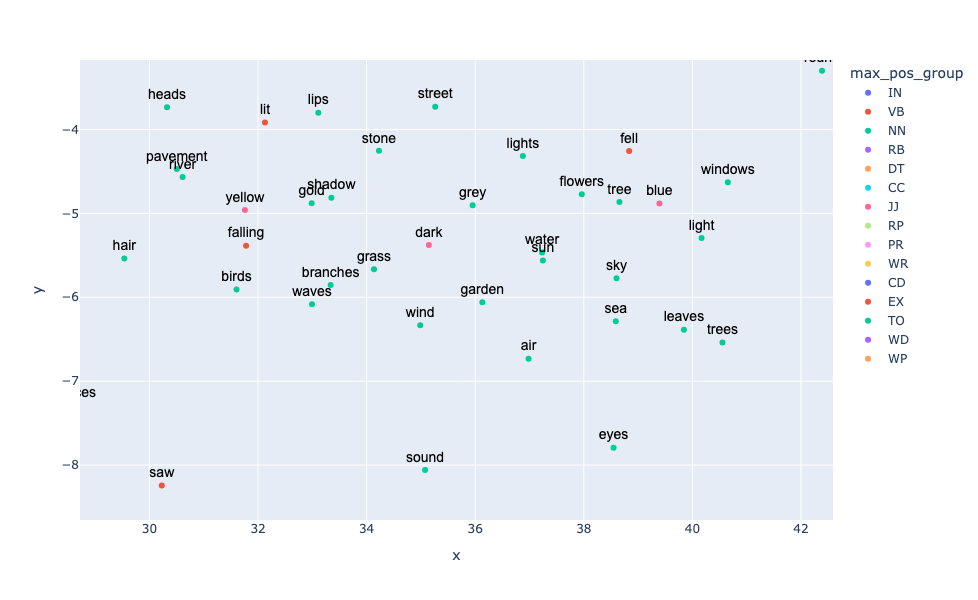

In [10]:
# add coordinates to VOCAB table
X = TSNE.join(VOCAB, how='left')

# plot
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        color='max_pos_group', 
        hover_name='term_str',          
        height=600,
        width=700)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

## Saving tables

In [12]:
VOCAB_W2V.to_csv("/Users/lucyshichman/Documents/MSDS/DS5001/final_project/woolf2vec/output/vocab_w2v.csv")

In [13]:
LIB

,source_file_path,title,chap_regex,year,goodreads
book_id,,,,,
BetweenTheActs,/Users/lucyshichman/Documents/MSDS/DS5001/fina...,BetweenTheActs,^###CHAPTER###$,1941,3.61
Flush,/Users/lucyshichman/Documents/MSDS/DS5001/fina...,Flush,^(CHAPTER\s+[A-Z]+)\s*$,1933,3.87
JacobsRoom,/Users/lucyshichman/Documents/MSDS/DS5001/fina...,JacobsRoom,^CHAPTER\s+[A-Z]+\s*$,1922,3.69
MrsDalloway,/Users/lucyshichman/Documents/MSDS/DS5001/fina...,MrsDalloway,^###CHAPTER###$,1925,3.73
NightAndDay,/Users/lucyshichman/Documents/MSDS/DS5001/fina...,NightAndDay,^CHAPTER\s+[IVXLCDM]+\s*$,1919,3.75
Orlando,/Users/lucyshichman/Documents/MSDS/DS5001/fina...,Orlando,^CHAPTER\s+\d+\.\s*$,1928,3.86
TheVoyageOut,/Users/lucyshichman/Documents/MSDS/DS5001/fina...,TheVoyageOut,^Chapter\s+[IVXLCDM]+\s*$,1915,3.75
TheWaves,/Users/lucyshichman/Documents/MSDS/DS5001/fina...,TheWaves,^###CHAPTER###$,1931,4.15
TheYears,/Users/lucyshichman/Documents/MSDS/DS5001/fina...,TheYears,^\s*(18|19)\d{2}\s*$,1937,3.77
